In [5]:
import gym
from gym import wrappers
import random
from tiles3 import IHT, tiles
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

env = gym.make('CartPole-v0')

# Episodic Semi-Gradient Sarsa(0)

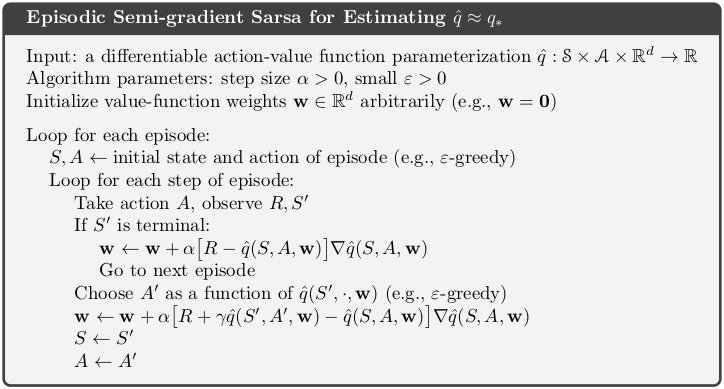

In [6]:
numtilings = 8
maxtiles = 30000 #2048 # memory for storing parameters
thetas = np.zeros(maxtiles) # weights
alpha = 0.01 # learning rate
gamma = 0.98 # discount rate
epsilon = 0.2 # probability of choosing a random action (changed from original value of 0.0)

hashTable = IHT(maxtiles)

In [7]:
# Get indices of active tiles for given state and action
def getActiveTiles(displacement, velocity, angularDisplacement, angularVelocity, action):
    global hashTable
    global env
    max_displacement, max_velocity, max_angularDisplacement, max_angularVelocity  = tuple(env.observation_space.high)
    min_displacement, min_velocity, min_angularDisplacement, min_angularVelocity  = tuple(env.observation_space.low)
    activeTiles = tiles(hashTable, 
                        numtilings,
                        [numtilings * displacement / (max_displacement - min_displacement), 
                         numtilings * velocity / (1),
                         numtilings * angularDisplacement / (max_angularDisplacement - min_angularDisplacement),
                         numtilings * angularVelocity / (1)],
                        [action])
    return activeTiles

def features(observation, action):
    tileIndices = getActiveTiles(observation[0], observation[1], observation[2], observation[3], action)
    feature = [0] * maxtiles
    for tile_index in tileIndices:
        feature[tile_index] = 1
    return feature

def qfunction(observation, action):
    global thetas
    return np.matmul(features(observation, action), thetas)

def delta(observation, action):
    return features(observation, action)

def take_action(observation):
    if random.random() > epsilon:
        return np.argmax([qfunction(observation, action) for action in range(env.action_space.n)])
    else:
        return random.randint(0, 1)

Episode# 0 finished after 10 timesteps with total rewards 10.0
Episode# 1 finished after 41 timesteps with total rewards 41.0
Episode# 2 finished after 25 timesteps with total rewards 25.0
Episode# 3 finished after 35 timesteps with total rewards 35.0
Episode# 4 finished after 36 timesteps with total rewards 36.0
Episode# 5 finished after 20 timesteps with total rewards 20.0
Episode# 6 finished after 20 timesteps with total rewards 20.0
Episode# 7 finished after 34 timesteps with total rewards 34.0
Episode# 8 finished after 26 timesteps with total rewards 26.0
Episode# 9 finished after 38 timesteps with total rewards 38.0
Episode# 10 finished with avg. rewards 40
Episode# 11 finished after 24 timesteps with total rewards 24.0
Episode# 12 finished after 24 timesteps with total rewards 24.0
Episode# 13 finished after 29 timesteps with total rewards 29.0
Episode# 14 finished after 27 timesteps with total rewards 27.0
Episode# 15 finished after 18 timesteps with total rewards 18.0
Episode#

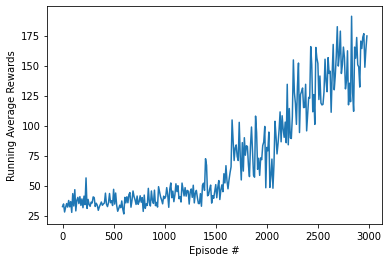

In [8]:
def learn():
    global thetas
    global env
    average_reward_list = []
    average_reward = 0

    # Loop for each episode
    for episode in range(3000):
        # Obtain the intial state
        observation = env.reset()
        total_reward = 0
        # Take an intial action based on e-greedy policy
        action = take_action(observation)
        timestep = 0
        # Loop for each step of episode
        while True:
            timestep += 1
            # Take above action and observe the reward and new state
            newObservation, reward, done, info = env.step(action)
            # Update rewards 
            total_reward += reward
            average_reward += reward
            # If the state is terminal
            if done:
                # Update weights
                change = alpha * (reward - qfunction(observation, action))
                thetas += change * np.array(delta(observation, action))
                # Go to next episode
                break
            # If state is not terminal
            # Set next action
            newAction = take_action(newObservation)
            # Update weights
            qdash = qfunction(newObservation, newAction)
            q = qfunction(observation, action)
            change = alpha * (reward + gamma * qdash - q)
            thetas += change * np.array(delta(observation, action))
            # Set next state
            observation = newObservation
            # Set next action
            action = newAction
        # Calculate running average over sliding window of 10
        if episode % 10 == 0 and episode != 0:
            average_reward_list.append(average_reward / 10)
            print("Episode# {} finished with avg. rewards {}".format(episode, timestep, average_reward / 10))
            average_reward = 0
        else:
            print("Episode# {} finished after {} timesteps with total rewards {}".format(episode, timestep, total_reward))
    env.close()
    
    '''# Plot average rewards
    plt.plot(average_reward_list)
    plt.xlabel('Episode #')
    plt.ylabel('Running Average Rewards')
    plt.show()'''

    # Plot average rewards
    plt.plot(average_reward_list)
    plt.xlabel('Episode #')
    plt.ylabel('Running Average Rewards')

    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
    plt.gca().xaxis.set_major_formatter(ticks_x)
    plt.ioff()
    plt.show()

if __name__ == "__main__":
    learn()

# Semi-Gradient TD(lambda)

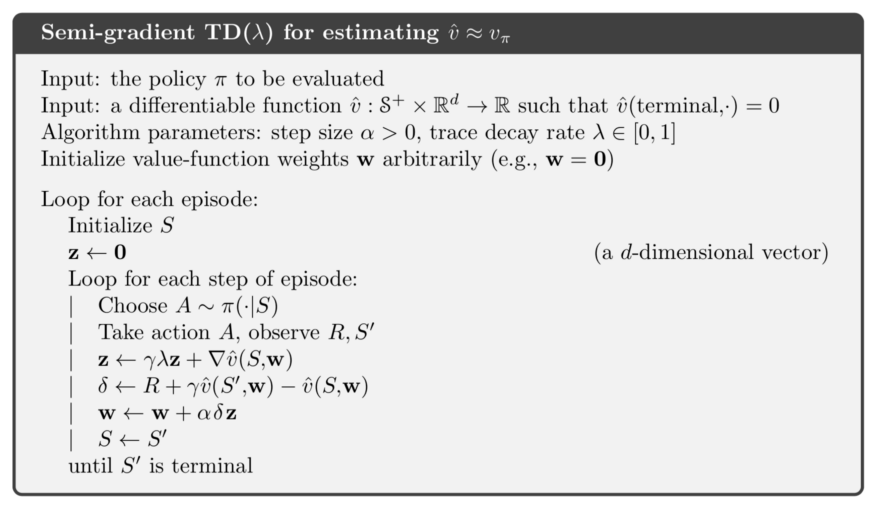

In [9]:
numtilings = 8
maxtiles = 30000 #2048 # memory for storing parameters
thetas = np.zeros(maxtiles) # weights
alpha = 0.01 # learning rate
gamma = 0.98 # discount rate
lambda_ = 0.92 # trace decay rate
epsilon = 0.2 # probability of choosing a random action (changed from original value of 0.0)

hashTable = IHT(maxtiles)

In [10]:
# get indices of active tiles for given state and action
def getActiveTiles(displacement, velocity, angularDisplacement, angularVelocity):
    global hashTable
    global env
    max_displacement, max_velocity, max_angularDisplacement, max_angularVelocity  = tuple(env.observation_space.high)
    min_displacement, min_velocity, min_angularDisplacement, min_angularVelocity  = tuple(env.observation_space.low)
    activeTiles = tiles(hashTable, 
                        numtilings,
                        [numtilings * displacement / (max_displacement - min_displacement), 
                         numtilings * velocity / (1),
                         numtilings * angularDisplacement / (max_angularDisplacement - min_angularDisplacement),
                         numtilings * angularVelocity / (1)])
    return activeTiles

# Featurise observation
def features(observation):
    tileIndices = getActiveTiles(observation[0], observation[1], observation[2], observation[3])
    feature = [0] * maxtiles
    for tile_index in tileIndices:
        feature[tile_index] = 1
    return feature

def vfunction(observation):
    global thetas
    return np.matmul(features(observation), thetas)

def delta(observation):
    return features(observation)

def take_action(observation):
    return random.randint(0, 1)

Episode# 0 finished after 24 timesteps with total rewards 24.0
Episode# 1 finished after 35 timesteps with total rewards 35.0
Episode# 2 finished after 11 timesteps with total rewards 11.0
Episode# 3 finished after 20 timesteps with total rewards 20.0
Episode# 4 finished after 37 timesteps with total rewards 37.0
Episode# 5 finished after 20 timesteps with total rewards 20.0
Episode# 6 finished after 31 timesteps with total rewards 31.0
Episode# 7 finished after 15 timesteps with total rewards 15.0
Episode# 8 finished after 23 timesteps with total rewards 23.0
Episode# 9 finished after 45 timesteps with total rewards 45.0
Episode# 10 finished with avg. rewards 15
Episode# 11 finished after 12 timesteps with total rewards 12.0
Episode# 12 finished after 47 timesteps with total rewards 47.0
Episode# 13 finished after 26 timesteps with total rewards 26.0
Episode# 14 finished after 8 timesteps with total rewards 8.0
Episode# 15 finished after 21 timesteps with total rewards 21.0
Episode# 1

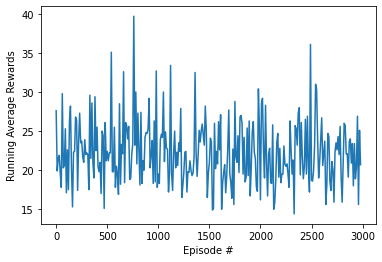

In [11]:
def learn():
    global thetas
    global env
    global lambda_
    average_reward_list = []
    average_reward = 0

    # Loop for each episode
    for episode in range(3000):
        # Obtain the intial state
        observation = env.reset()
        # Initialise eligibility trace
        z = np.zeros(maxtiles)
        # Update rewards
        total_reward = 0
        timestep = 0
        # Loop for each step of episode and if state is not terminal
        while True:
            timestep += 1
            action = take_action(observation) 
            # Take above action and observe the reward and new state
            newObservation, reward, done, info = env.step(action)
            total_reward += reward
            average_reward += reward
            # Update trace and weights
            z = z*gamma*lambda_ + np.array(delta(observation)) # update current z -> z matrix * gamma * lambda
            vdash = vfunction(newObservation)
            v = vfunction(observation)
            change = reward + gamma * vdash - v
            thetas += alpha*change*z #* np.array(delta(observation))
            # Set next state
            observation = newObservation
            # If episode is terminal
            if done:
              break
        # Calculate running average over sliding window of 10
        if episode % 10 == 0 and episode != 0:
            average_reward_list.append(average_reward / 10)
            print("Episode# {} finished with avg. rewards {}".format(episode, timestep, average_reward / 10))
            average_reward = 0
        else:
            print("Episode# {} finished after {} timesteps with total rewards {}".format(episode, timestep, total_reward))
    env.close()
    
    '''# Plot average rewards
    plt.plot(average_reward_list)
    plt.xlabel('Episode #')
    plt.ylabel('Running Average Rewards')
    plt.show()'''

    # Plot average rewards
    plt.plot(average_reward_list)
    plt.xlabel('Episode #')
    plt.ylabel('Running Average Rewards')

    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
    plt.gca().xaxis.set_major_formatter(ticks_x)
    plt.ioff()
    plt.show()

if __name__ == "__main__":
    learn()